In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [274]:
df = pd.read_csv('datasets/CNN_parameter_dataset.csv')
int_flow = df.copy()
int_flow.head()

,Sample,Cavity,Voltage,Flow rate,Duty cycle,Pulse width,Pulse period,Pulse pkpk,Pulse rms,Laser energy,cavity width(mm),cavity depth(µm)
0,5,6,25,0.47,20,4,20,3.132333,1.318667,0,2.285,72.1
1,5,7,25,0.47,20,4,20,3.010667,1.273267,0,2.199,68.2
2,5,8,25,0.47,20,4,20,3.329467,1.397467,0,2.108,67.2
3,5,9,25,0.47,20,4,20,3.260867,1.379214,0,2.233,61.2
4,5,10,25,0.47,20,4,20,3.198667,1.348800,0,2.046,52.2


In [275]:
#preparing the dataset for spliting into features and labels 
int_flow.columns = [col.strip() for col in df.columns]
int_flow.drop(['Sample','Cavity','Pulse width'], axis=1, inplace=True)
int_flow['cavity width(mm)'] = int_flow['cavity width(mm)']*1000
#int_flow = sklearn.utils.shuffle(int_flow)
int_flow.head()

,Voltage,Flow rate,Duty cycle,Pulse period,Pulse pkpk,Pulse rms,Laser energy,cavity width(mm),cavity depth(µm)
0,25,0.47,20,20,3.132333,1.318667,0,2285.0,72.1
1,25,0.47,20,20,3.010667,1.273267,0,2199.0,68.2
2,25,0.47,20,20,3.329467,1.397467,0,2108.0,67.2
3,25,0.47,20,20,3.260867,1.379214,0,2233.0,61.2
4,25,0.47,20,20,3.198667,1.348800,0,2046.0,52.2


In [276]:
X = int_flow.drop(['cavity width(mm)', 'cavity depth(µm)'], axis=1).values
#X = preprocessing.scale(X)
y = int_flow[['cavity depth(µm)']].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=5)

In [277]:
X_train_1, X_dev, y_train_1, y_dev = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=5)

In [253]:
#defining a neural network model
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [278]:
#training the neuralnetwork model
X_train_1 = torch.tensor(X_train_1)
y_train_1 = torch.tensor(y_train_1)

X_dev = torch.tensor(X_dev)
y_dev = torch.tensor(y_dev)

X_train_1.shape, y_train_1.shape   

(torch.Size([62, 7]), torch.Size([62, 1]))

In [279]:
from tqdm import tqdm

net = Net()

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)

# to track the training loss as the model trains
t_l = []
# to track the validation loss as the model trains
d_l = []

#initialize the early_stopping object
early_stopping = EarlyStopping(patience=100, verbose=True)

for epoch in tqdm(range(10000)):# 10000 full passes over the data        
    net.zero_grad() # sets gradients to 0 before loss calc. You will do this likely every step.
    output = net(X_train_1.float()) # pass in the training batch 
    loss = loss_function(output, y_train_1.float()) # calc and grab the loss value
    loss.backward() # apply this loss backwards thru the network's parameters
    optimizer.step() # attempt to optimize weights to account for loss/gradients
    if epoch%5 == 0: 
        with torch.no_grad():
            y_predict = net(X_dev.float())
            dev_error = loss_function(y_predict, y_dev.float())
            #print(f'train_loss..:{loss.item()} dev_loss..:{dev_error.item()} ')
            t_l.append(loss.item())
            d_l.append(dev_error.item())
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(dev_error, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break  
            #print(loss) # print loss. We hope loss (train_loss..:{loss.item()} a measure of wrong-ness) declines!

  1%|▊                                                                           | 108/10000 [00:00<00:09, 1044.96it/s]

Validation loss decreased (inf --> 10143.603516).  Saving model ...
Validation loss decreased (10143.603516 --> 8732.935547).  Saving model ...
Validation loss decreased (8732.935547 --> 5037.841797).  Saving model ...
Validation loss decreased (5037.841797 --> 744.672546).  Saving model ...
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 4 out of 100
EarlyStopping counter: 5 out of 100
EarlyStopping counter: 6 out of 100
EarlyStopping counter: 7 out of 100
EarlyStopping counter: 8 out of 100
EarlyStopping counter: 9 out of 100
EarlyStopping counter: 10 out of 100
EarlyStopping counter: 11 out of 100
EarlyStopping counter: 12 out of 100
EarlyStopping counter: 13 out of 100
EarlyStopping counter: 14 out of 100
EarlyStopping counter: 15 out of 100
EarlyStopping counter: 16 out of 100
EarlyStopping counter: 17 out of 100
EarlyStopping counter: 18 out of 100
EarlyStopping counter: 19 out of 100
EarlyStopping

  4%|███                                                                         | 397/10000 [00:00<00:07, 1337.43it/s]

EarlyStopping counter: 43 out of 100
EarlyStopping counter: 44 out of 100
EarlyStopping counter: 45 out of 100
EarlyStopping counter: 46 out of 100
EarlyStopping counter: 47 out of 100
EarlyStopping counter: 48 out of 100
EarlyStopping counter: 49 out of 100
EarlyStopping counter: 50 out of 100
EarlyStopping counter: 51 out of 100
EarlyStopping counter: 52 out of 100
EarlyStopping counter: 53 out of 100
EarlyStopping counter: 54 out of 100
EarlyStopping counter: 55 out of 100
EarlyStopping counter: 56 out of 100
EarlyStopping counter: 57 out of 100
EarlyStopping counter: 58 out of 100
EarlyStopping counter: 59 out of 100
EarlyStopping counter: 60 out of 100
EarlyStopping counter: 61 out of 100
EarlyStopping counter: 62 out of 100
EarlyStopping counter: 63 out of 100
EarlyStopping counter: 64 out of 100
EarlyStopping counter: 65 out of 100
EarlyStopping counter: 66 out of 100
EarlyStopping counter: 67 out of 100
EarlyStopping counter: 68 out of 100
EarlyStopping counter: 69 out of 100
E

  5%|███▉                                                                        | 515/10000 [00:00<00:07, 1284.28it/s]

EarlyStopping counter: 92 out of 100
EarlyStopping counter: 93 out of 100
EarlyStopping counter: 94 out of 100
EarlyStopping counter: 95 out of 100
EarlyStopping counter: 96 out of 100
EarlyStopping counter: 97 out of 100
EarlyStopping counter: 98 out of 100
EarlyStopping counter: 99 out of 100
EarlyStopping counter: 100 out of 100
Early stopping


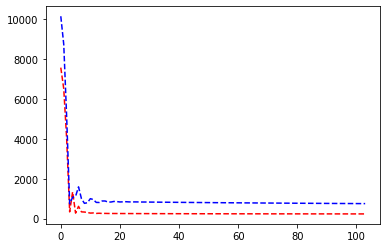

In [280]:
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
#t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t_l,'r--', d_l,'b--')
plt.show()

In [281]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

y_predict_1 = net(X_test.float())
error = loss_function(y_predict_1, y_test.float())

print(error.item())
for a in (list(zip(y_test,y_predict_1))):
    print(a)
    
print(r2_score(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MAPE for depth: ', mean_absolute_percentage_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

print('MSE for depth: ', mean_squared_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))

371.28546142578125
(tensor([97.6000], dtype=torch.float64), tensor([91.7768], grad_fn=<UnbindBackward0>))
(tensor([108.], dtype=torch.float64), tensor([90.1677], grad_fn=<UnbindBackward0>))
(tensor([79.7000], dtype=torch.float64), tensor([94.6858], grad_fn=<UnbindBackward0>))
(tensor([66.2000], dtype=torch.float64), tensor([81.1412], grad_fn=<UnbindBackward0>))
(tensor([78.4000], dtype=torch.float64), tensor([96.9620], grad_fn=<UnbindBackward0>))
(tensor([107.5000], dtype=torch.float64), tensor([91.4405], grad_fn=<UnbindBackward0>))
(tensor([39.7200], dtype=torch.float64), tensor([81.1869], grad_fn=<UnbindBackward0>))
(tensor([80.3000], dtype=torch.float64), tensor([85.0327], grad_fn=<UnbindBackward0>))
(tensor([138.], dtype=torch.float64), tensor([92.7584], grad_fn=<UnbindBackward0>))
(tensor([112.1000], dtype=torch.float64), tensor([91.6899], grad_fn=<UnbindBackward0>))
(tensor([103.3000], dtype=torch.float64), tensor([90.3627], grad_fn=<UnbindBackward0>))
(tensor([96.2000], dtype=to

In [8]:
import os, pathlib, random

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



class EarlyStopping:
	"""Early stops the training if validation loss doesn't improve after a given patience."""
	def __init__(self, patience, verbose=False, delta=0, save_path='checkpoint.pt'):
		"""
		Args:
			patience (int): How long to wait after last time validation loss improved.
							Default: 7
			verbose (bool): If True, prints a message for each validation loss improvement.
							Default: False
			delta (float): Minimum change in the monitored quantity to qualify as an improvement.
							Default: 0
		"""
		self.patience = patience
		self.verbose = verbose
		self.counter = 0
		self.best_score = None
		self.early_stop = False
		self.val_loss_min = np.inf
		self.delta = delta
		self.save_path = save_path
		os.makedirs(pathlib.Path(self.save_path).parent, exist_ok=True)

	def __call__(self, val_loss, model):

		score = -val_loss

		if self.best_score is None:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
		elif score < self.best_score - self.delta:
			self.counter += 1
			print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
			if self.counter >= self.patience:
				self.early_stop = True
		else:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
			self.counter = 0

	def save_checkpoint(self, val_loss, model):
		"""Saves model when validation loss decrease."""
		if self.verbose:
			print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
		torch.save(model.state_dict(), self.save_path)
		self.val_loss_min = val_loss

In [241]:
X_train_1

tensor([[1.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 1.8129e+00, 1.2348e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.5266e+00, 1.6963e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.1053e+00, 1.4225e+00,
         0.0000e+00],
        [2.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 7.1144e-01, 4.9267e-01,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.6967e-01, 1.7533e-01,
         5.0000e+01],
        [2.5000e+01, 4.7000e-01, 2.0000e+01, 2.0000e+01, 3.2609e+00, 1.3792e+00,
         0.0000e+00],
        [3.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.8456e+00, 1.8818e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 5.0000e+01, 2.3254e+00, 1.6061e+00,
         0.0000e+00],
        [3.0000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.3681e+00, 1.6029e+00,
         0.0000e+00],
        [2.5000e+01, 4.7000e-01, 5.0000e+01, 2.0000e+01, 2.6037e+00, 1.75